In [1]:
using WindTunnelFlow
using Plots

In [2]:
function suction_velocity!(vel,pts,t,phys_params)
    V_out = phys_params["V_SD"]
    σ = phys_params["sigma_suction"]
    t_0 = phys_params["t_suction"]
    g = Gaussian(σ,sqrt(π*σ^2)) >> t_0
    vel .= -V_out*g(t)
end

function inflow_velocity!(vel,pts,t,phys_params)
    V_in = phys_params["V_in"]
    vel .= V_in
end

inflow_velocity! (generic function with 1 method)

In [3]:
# Airfoil characteristics

c = 0.245 # m
α = 0 # degrees

0

In [4]:
# Wind tunnel characteristics

H_TS = 0.61 # m
W_TS = 0.61 # m
L_TS = 2.1 # m

V_in = 1.0 * c # m/s
Q_SD_over_Q_in = 0.3
x_SD_lo_over_L_TS = 0.4
x_SD_hi_over_L_TS = 0.6

0.6

In [5]:
# Rescale every length by the chord length
c_star = c / c
H_TS_star = H_TS / c
W_TS_star = W_TS / c
L_TS_star = L_TS / c
V_in_star = V_in / c # m/s

1.0

In [6]:
A_TS_star = H_TS_star * W_TS_star
Q_in_star = V_in_star * A_TS_star
Q_SD_star = Q_SD_over_Q_in * Q_in_star

x_SD_lo_star = x_SD_lo_over_L_TS * L_TS_star
x_SD_hi_star = x_SD_hi_over_L_TS * L_TS_star
L_SD_star = x_SD_hi_star - x_SD_lo_star
A_SD_star = L_SD_star * W_TS_star
V_SD_star = Q_SD_star / A_SD_star

x_O_WT_star = -L_TS_star/2
y_O_WT_star = -H_TS_star/2

-1.2448979591836735

In [7]:
params = Dict()
params["Re"] = 400
params["grid Re"] = 6.0
params["wind tunnel length"] = L_TS_star
params["wind tunnel height"] = H_TS_star
params["wind tunnel center"] = (L_TS_star / 2 + x_O_WT_star, H_TS_star / 2 + y_O_WT_star)
params["freestream speed"] = V_in_star
params["freestream angle"] = 0.0
params["sigma_suction"] = 0.2
params["t_suction"] = 3.0
params["V_in"] = V_in_star
params["V_SD"] = V_SD_star
t_final = 5.0
xlim = (-0.05 * L_TS_star + x_O_WT_star, 1.05 * L_TS_star + x_O_WT_star)
ylim = (-0.05 * H_TS_star + y_O_WT_star, 1.05 * H_TS_star + y_O_WT_star)
g = setup_grid(xlim, ylim, params)

PhysicalGrid{2}((640, 192), (320, 96), 0.015, ((-4.785, 4.785), (-1.425, 1.425)))

In [8]:
# Airfoil in the test section

Δs = surface_point_spacing(g,params)
airfoil = NACA4(0.0, 0.0, 0.09, 300, len=c_star)
airfoil = SplinedBody(airfoil.x, airfoil.y, Δs)
T = RigidTransform((L_TS_star / 2 + x_O_WT_star, H_TS_star / 2 + y_O_WT_star), -α*π/180)
T(airfoil) # transform the body to the current configuration

Basic pointwise-specified body with 96 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


In [9]:
# Create the inflow

N = ceil(Int, H_TS_star / surface_point_spacing(g,params))
inflow_boundary = BasicBody(
    ones(N) * x_O_WT_star,
    collect(range(0, H_TS_star, N)) .+ y_O_WT_star,
    closuretype=RigidBodyTools.OpenBody)
inflow = UniformFlowThrough(inflow_boundary,inflow_velocity!,3)

params["inlets"] = [inflow]

1-element Vector{UniformFlowThrough}:
 UniformFlowThrough(Basic pointwise-specified body with 118 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
, inflow_velocity!, 3, [-4.285714285714286, -4.285714285714286, -4.285714285714286, -4.285714285714286, -4.285714285714286, -4.285714285714286, -4.285714285714286, -4.285714285714286, -4.285714285714286, -4.285714285714286  …  1.0444482877896921, 1.0655482531995848, 1.0866482186094777, 1.1077481840193704, 1.128848149429263, 1.149948114839156, 1.1710480802490488, 1.1921480456589415, 1.2132480110688342, 1.234347976478727], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [10]:
# Create the suction at the top of the wind tunnel

N = ceil(Int, L_SD_star / surface_point_spacing(g,params))
suction_boundary = BasicBody(
    collect(range(x_SD_lo_star, x_SD_hi_star, N)) .+ x_O_WT_star,
    H_TS_star * ones(N) .+ y_O_WT_star;
    closuretype=RigidBodyTools.OpenBody)
suction = UniformFlowThrough(suction_boundary,suction_velocity!,1)

params["outlets"] = [suction]

1-element Vector{UniformFlowThrough}:
 UniformFlowThrough(Basic pointwise-specified body with 81 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
, suction_velocity!, 1, [-0.8465608465608463, -0.8253968253968251, -0.804232804232804, -0.7830687830687828, -0.7619047619047616, -0.7407407407407405, -0.7195767195767193, -0.6984126984126982, -0.677248677248677, -0.6560846560846558  …  1.2448979591836735, 1.2448979591836735, 1.2448979591836735, 1.2448979591836735, 1.2448979591836735, 1.2448979591836735, 1.2448979591836735, 1.2448979591836735, 1.2448979591836735, 1.2448979591836735], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

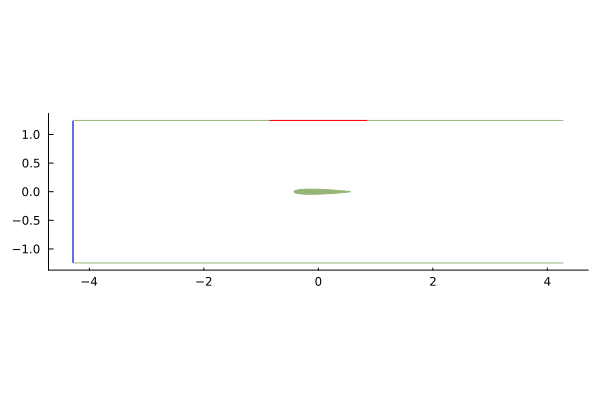

In [11]:
wt_walls = create_windtunnel_boundaries(g,params,withinlet=true)
plot(airfoil)
plot!(wt_walls,xlim=xlim,ylim=ylim)
plot!(suction.boundary,lc=:red)
plot!(inflow.boundary,lc=:blue)

In [12]:
prob = WindTunnelProblem(g,airfoil,phys_params=params;timestep_func=ViscousFlow.DEFAULT_TIMESTEP_FUNC,
                                   bc=ViscousFlow.get_bc_func(nothing))
sys = construct_system(prob);

In [13]:
u0 = init_sol(sys)
tspan = (0.0,t_final)
integrator = init(u0,tspan,sys);

In [14]:
for (u,t) in tuples(integrator)
    @show t
end

t = 0.0075
t = 0.015
t = 0.0225
t = 0.03
t = 0.0375
t = 0.045
t = 0.0525
t = 0.06
t = 0.0675
t = 0.07500000000000001
t = 0.08250000000000002
t = 0.09000000000000002
t = 0.09750000000000003
t = 0.10500000000000004
t = 0.11250000000000004
t = 0.12000000000000005
t = 0.12750000000000006
t = 0.13500000000000006
t = 0.14250000000000007
t = 0.15000000000000008
t = 0.15750000000000008
t = 0.1650000000000001
t = 0.1725000000000001
t = 0.1800000000000001
t = 0.1875000000000001
t = 0.19500000000000012
t = 0.20250000000000012
t = 0.21000000000000013
t = 0.21750000000000014
t = 0.22500000000000014
t = 0.23250000000000015
t = 0.24000000000000016
t = 0.24750000000000016
t = 0.25500000000000017
t = 0.2625000000000002
t = 0.2700000000000002
t = 0.2775000000000002
t = 0.2850000000000002
t = 0.2925000000000002
t = 0.3000000000000002
t = 0.3075000000000002
t = 0.3150000000000002
t = 0.32250000000000023
t = 0.33000000000000024
t = 0.33750000000000024
t = 0.34500000000000025
t = 0.35250000000000026
t = 0.3

t = 2.774999999999989
t = 2.7824999999999886
t = 2.7899999999999885
t = 2.7974999999999883
t = 2.804999999999988
t = 2.812499999999988
t = 2.819999999999988
t = 2.8274999999999877
t = 2.8349999999999875
t = 2.8424999999999874
t = 2.849999999999987
t = 2.857499999999987
t = 2.864999999999987
t = 2.8724999999999867
t = 2.8799999999999866
t = 2.8874999999999864
t = 2.8949999999999863
t = 2.902499999999986
t = 2.909999999999986
t = 2.9174999999999858
t = 2.9249999999999856
t = 2.9324999999999855
t = 2.9399999999999853
t = 2.947499999999985
t = 2.954999999999985
t = 2.962499999999985
t = 2.9699999999999847
t = 2.9774999999999845
t = 2.9849999999999843
t = 2.992499999999984
t = 2.999999999999984
t = 3.007499999999984
t = 3.0149999999999837
t = 3.0224999999999835
t = 3.0299999999999834
t = 3.037499999999983
t = 3.044999999999983
t = 3.052499999999983
t = 3.0599999999999827
t = 3.0674999999999826
t = 3.0749999999999824
t = 3.0824999999999823
t = 3.089999999999982
t = 3.097499999999982
t = 3.10

In [15]:
sol = integrator.sol;
fx, fy = force(sol,sys,1);

In [16]:
anim_sample_freq = 5 # samples per simulated time unit
anim_fps = 24 # frames per second of real time
Δt = prob.timestep_func(sys) # simulated time per time step
anim_sample_step = ceil(Int,1/(Δt*anim_sample_freq)) # time steps per sample

27

In [17]:
pts = points(suction.boundary)
vel = ScalarData(pts)
Q_suction = []
for i in 1:length(sol.t)
    suction_velocity!(vel,suction.boundary,sol.t[i],params)
    Q_suction_i = -integrate(vel,ScalarData(dlength(suction.boundary))) * W_TS_star
    push!(Q_suction,Q_suction_i)
end

In [18]:
y_O_WT_star

-1.2448979591836735

┌ Info: Saved animation to /Users/beckers/.julia/dev/WindTunnelFlow/examples/tmp.gif
└ @ Plots /Users/beckers/.julia/packages/Plots/gzYVM/src/animation.jl:149


Plots.AnimatedGif("/Users/beckers/.julia/dev/WindTunnelFlow/examples/tmp.gif")
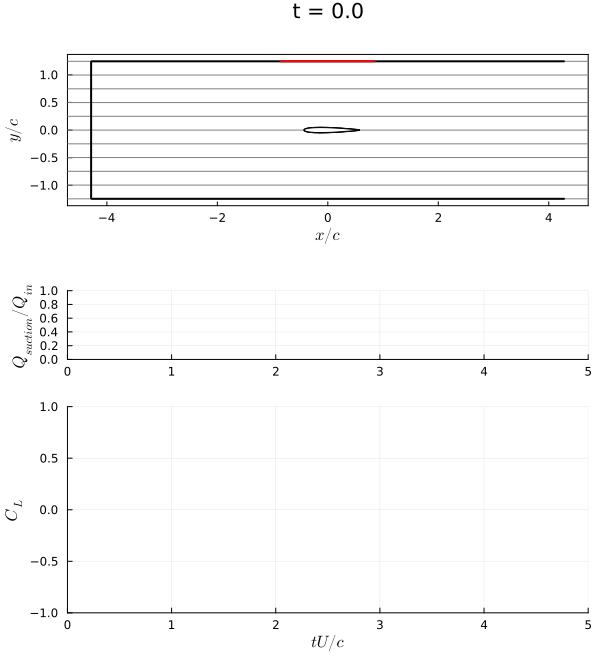

In [19]:
ψ = zeros_gridcurl(sys)
ViscousFlow.streamfunction!(ψ,sol.u[end].x[1],sys,sol.t[end])
y_probe = (0:0.1*H_TS_star:H_TS_star) .+ y_O_WT_star

anim = @animate for i in 1:anim_sample_step:length(sol.t)
#     l = @layout [a{0.6w} [Plots.grid(2,1)]]    
    ViscousFlow.streamfunction!(ψ,sol.u[i].x[1],sys,sol.t[i])
    ψ_fcn = interpolatable_field(ψ,g)
    ψ_probe = ψ_fcn.(x_O_WT_star,y_probe)
    p1=plot(ψ,sys,c=:gray,levels=ψ_probe,title="t = $(round(integrator.sol.t[i]; digits=1))",xlabel="\$x/c\$",ylabel="\$y/c\$",clim=(-10,10))
    plot!(sol.u[i].x[1],sys,clim=(-15,15),color=cgrad(:RdBu, rev = true),levels=range(-15,15,length=30))
    plot!(wt_walls,xlim=xlim,ylim=ylim,lc=:black,lw=2)
    plot!(suction.boundary,lc=:red,lw=2)
    plot!(airfoil,fc=:white,lc=:black)
    p2=plot(sol.t[1:i],Q_suction[1:i]/Q_in_star,xlim=(0.0,sol.t[end]),ylim=(0,1),ylabel="\$Q_{suction}/Q_{in}\$",legend=false)
    p3=plot(sol.t[1:i],fy[1:i],xlim=(0.0,integrator.sol.t[end]),ylim=(-1,1),xlabel="\$tU/c\$",ylabel="\$C_L\$",legend=false)
#     plot(p1,p2,p3,layout = l,size=(1000,300),margin=4mm)
    plot(p1,p2,p3, layout=Plots.grid(3, 1, heights=[0.4 ,0.15, 0.45]),size=(600,670))
end
gif(anim)

## Viscous flow and Wagner response for comparison

First compute vertical velocity history at the midpoint of the airfoil and use that as the vertical velocity of the airfoil

In [20]:
probe_prob = WindTunnelProblem(g,phys_params=params;timestep_func=ViscousFlow.DEFAULT_TIMESTEP_FUNC,
                                   bc=ViscousFlow.get_bc_func(nothing))
probe_sys = construct_system(probe_prob);

center = (L_TS_star / 2 + x_O_WT_star, H_TS_star / 2 + y_O_WT_star)
LE = (center[1] - 1/2*cos(α*π/180), center[2] + 1/2*sin(α*π/180))
TE = (center[1] + 1/2*cos(α*π/180), center[2] - 1/2*sin(α*π/180))

Umid_hist = Vector()
ULE_hist = Vector()
UTE_hist = Vector()

Vmid_hist = Vector()
VLE_hist = Vector()
VTE_hist = Vector()

wt_vel = zeros_grid(sys);

for i in 1:length(sol.t) 
    ViscousFlow.velocity!(wt_vel, zeros_gridcurl(sys), sys, sol.t[i]);
    vel_fcn = interpolatable_field(wt_vel,g);
    
    push!(Umid_hist,vel_fcn[1](center[1],center[2]))
    push!(ULE_hist,vel_fcn[1](LE[1],LE[2]))
    push!(UTE_hist,vel_fcn[1](TE[1],TE[2]))
    
    push!(Vmid_hist,vel_fcn[2](center[1],center[2]))
    push!(VLE_hist,vel_fcn[2](LE[1],LE[2]))
    push!(VTE_hist,vel_fcn[2](TE[1],TE[2]))
end

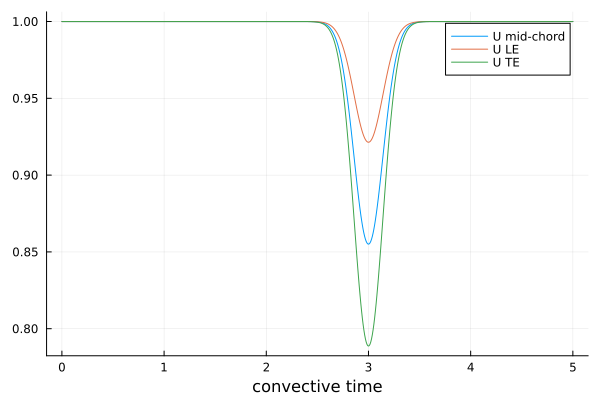

In [21]:
plot(integrator.sol.t,Umid_hist,label="U mid-chord",xlabel="convective time")
plot!(integrator.sol.t,ULE_hist,label="U LE")
plot!(integrator.sol.t,UTE_hist,label="U TE")

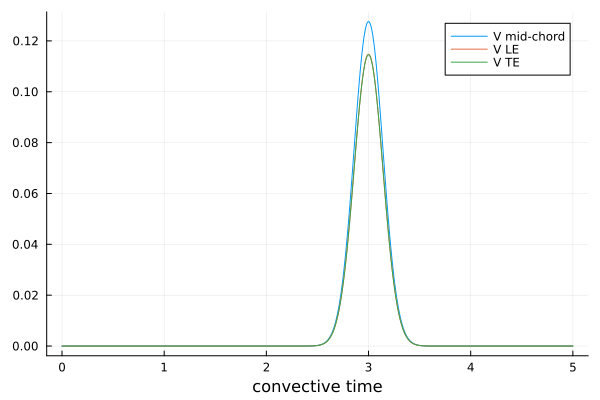

In [22]:
plot(integrator.sol.t,Vmid_hist,label="V mid-chord",xlabel="convective time")
plot!(integrator.sol.t,VLE_hist,label="V LE")
plot!(integrator.sol.t,VTE_hist,label="V TE")

In [23]:
function gaussian_freestream(t,phys_params)
    Uinf = get(phys_params,"freestream speed",0.0)
    U_mid = get(phys_params,"U_mid",0.0)
    V_mid = get(phys_params,"V_mid",0.0)
    σ = phys_params["sigma_suction"]
    t_0 = phys_params["t_suction"]
    g = Gaussian(σ,sqrt(π*σ^2)) >> t_0
    return Uinf - (Uinf - U_mid)*g(t), V_mid*g(t)
end

gaussian_freestream (generic function with 1 method)

In [24]:
params["U_mid"] = minimum(Umid_hist)
params["V_mid"] = maximum(Vmid_hist)
forcing_dict = Dict("freestream" => gaussian_freestream)

Dict{String, typeof(gaussian_freestream)} with 1 entry:
  "freestream" => gaussian_freestream

### Viscous flow response

In [25]:
viscous_prob = ViscousIncompressibleFlowProblem(g,airfoil,phys_params=params;timestep_func=ViscousFlow.DEFAULT_TIMESTEP_FUNC,
                                   bc=ViscousFlow.get_bc_func(nothing),forcing=forcing_dict)
viscous_sys = construct_system(viscous_prob);

In [26]:
u0 = init_sol(viscous_sys)
tspan = (0.0,t_final)
integrator = init(u0,tspan,viscous_sys);

In [27]:
step!(integrator,t_final)
sol = integrator.sol;
fx_viscous, fy_viscous = force(sol,viscous_sys,1);

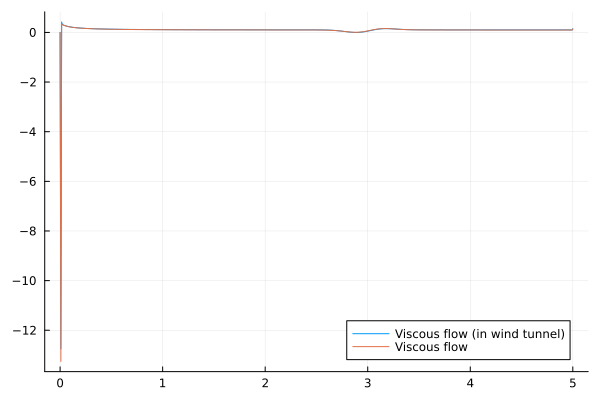

In [28]:
plot(sol.t,fx,label="Viscous flow (in wind tunnel)",legend=:bottomright)
plot!(sol.t,fx_viscous,label="Viscous flow")

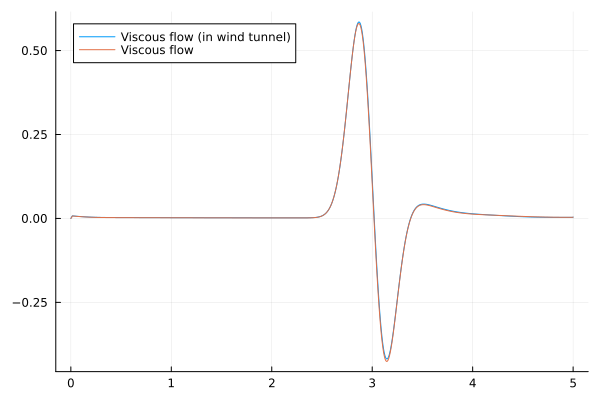

In [29]:
plot(sol.t,fy,label="Viscous flow (in wind tunnel)",legend=:topleft)
plot!(sol.t,fy_viscous,label="Viscous flow")

### Wagner response

Can implement a better version here (see AeroGym implementation)

In [30]:
Φ(t) = t ≥ 0 ? 1.0 - 0.165*exp(-0.091*t) - 0.335*exp(-0.6*t) : 0.0

Φ (generic function with 1 method)

In [31]:
function duhamelintegral(f_array,t_array,ind_fun)
    s = 0.0
    Δt = diff(t_array)
    for i in 2:length(t_array)
        s += f_array[i]*ind_fun(t_array[end]-t_array[i])*Δt[i-1]
    end
    return s
end

duhamelintegral (generic function with 1 method)

In [32]:
ḣ_old = 0.0
Γb_old = 0.0
fy_wagner = Vector()
Γ̇b_hist = Vector()

Δt_hist = diff(sol.t)

Γ_b0 = -π*c_star*V_in_star*α*pi/180

for i in 1:length(integrator.sol.t)-1
    ḣ = -Vmid_hist[i+1]
    ḧ = (ḣ-ḣ_old)/Δt_hist[i]
    ḣ_old = ḣ
    Γb = π*c_star*ḣ
    Γ̇b = (Γb-Γb_old)/Δt_hist[i]
    Γb_old = Γb
    
    push!(Γ̇b_hist,Γ̇b)

    fy_wagner_added_mass_i = -π/4*c_star^2*ḧ
    fy_wagner_i = fy_wagner_added_mass_i - Γ_b0 * Φ(sol.t[i]) - duhamelintegral(Γ̇b_hist,sol.t[2:i],Φ)
    
    push!(fy_wagner,fy_wagner_i)
end

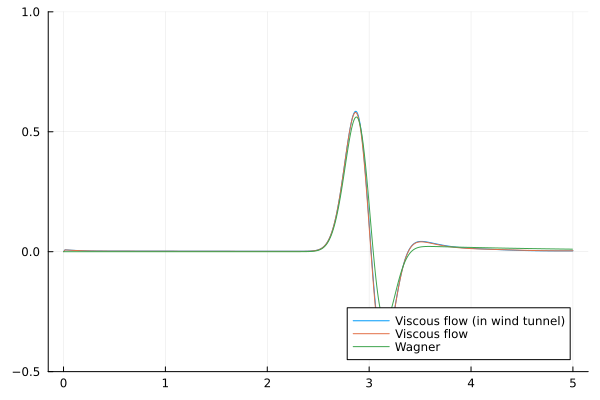

In [33]:
plot(sol.t,fy,label="Viscous flow (in wind tunnel)",legend=:bottomright,ylim=[-0.5,1])
plot!(sol.t,fy_viscous,label="Viscous flow")
plot!(sol.t[1:end-1],fy_wagner,label="Wagner")